In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
from nltk.stem.porter import *

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.python import keras
from keras.models import Sequential
from keras import layers

%matplotlib inline

D:\Applications\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('train.csv') 
test_data = pd.read_csv('test.csv')

In [3]:
y_train = train_data['label']

In [4]:
train_data_len = len(train_data)

In [5]:
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


# Removing Twitter Handles

In [7]:
# concatenating the training data set and the test data set to get a the complete data set

comp_data = train_data.append(test_data, ignore_index=True)

In [8]:
# a function is defined to remove patterns in text. Here the pattern that we are removing are the twitter handles as they
# don't hold much significance

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    
    return input_txt

In [9]:
# the formatted data is then stored to a new feature called the cleaned_tweets where the formatted tweets for each example
# are stored to create a cleaned vocabulary

comp_data['cleaned_tweets'] = np.vectorize(remove_pattern)(comp_data['tweet'], "@[\w]*")

In [10]:
comp_data.head()

,id,label,tweet,cleaned_tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [11]:
# replacing numbers and other special characters with a space in the cleaned_tweets elements

comp_data['cleaned_tweets'] = comp_data['cleaned_tweets'].str.replace("[^a-zA-Z#]", " ")

In [12]:
comp_data.head()

,id,label,tweet,cleaned_tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


## Removing words of length less than 3

In [13]:
# There are going to be many words like 'we', 'i' etc., which don't provide us with a lot of information. Hence we are 
# going to remove such words from our vocabulary and have words which gives us the most valued output.

comp_data['cleaned_tweets'] = comp_data['cleaned_tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [14]:
comp_data.head()

,id,label,tweet,cleaned_tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


## Tokenizing tweets

In [15]:
# The tweets in the cleaned_tweets feature are then tokenized. Tokenization means to split all the words in a given 
# sentence into individual words. These individual words are stored as a list in their respective row indexes

tokenized_tweet = comp_data['cleaned_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: cleaned_tweets, dtype: object

In [16]:
# Stemmer is a process of removing morphological affixes from the words. 

stemmer = PorterStemmer()

In [17]:
# all the words in the tokenized tweet are stemmed to give their root form. This process is implemented because
# there might be different forms of the same word in the tweets. For example, let's take the word 'drag'. The different
# forms of drag are drags, dragging, dragged etc., These different forms might be present in different tweets. 
# 
# Considering the different forms of a word is going to increase the length of our corpus, there by increasing the length
# of our vocabulary. These different forms of the word would mean almost the same in the sentences. Hence when stemming
# is implemented, we get the core form of the word and helps in shrinking the total number of elements in our corpus.

# The alternative for stemmer is lemmatizer

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: cleaned_tweets, dtype: object

In [18]:
# joining all the words of the tweets in the tokenized_tweet and assigning it back to the cleaned_tweets feature for further
# implementation

tokenized_tweet = [' '.join(i) for i in tokenized_tweet]

comp_data['cleaned_tweets'] = tokenized_tweet

In [19]:
comp_data['cleaned_tweets'].head()

0    when father dysfunct selfish drag kid into dys...
1    thank #lyft credit caus they offer wheelchair ...
2                                  bihday your majesti
3                           #model love take with time
4                             factsguid societi #motiv
Name: cleaned_tweets, dtype: object

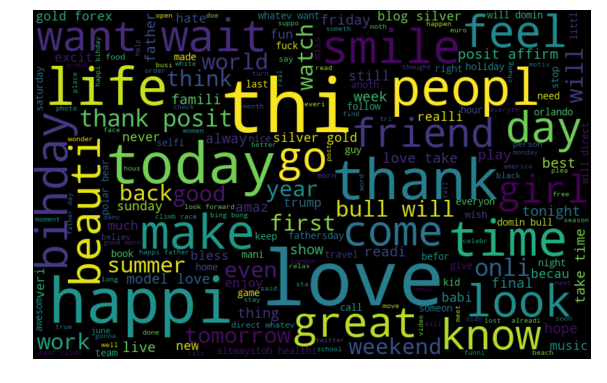

In [20]:
# wordcloud gives you a visual form of the most occuring words in the corpus

all_words = ' '.join([text for text in comp_data['cleaned_tweets']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

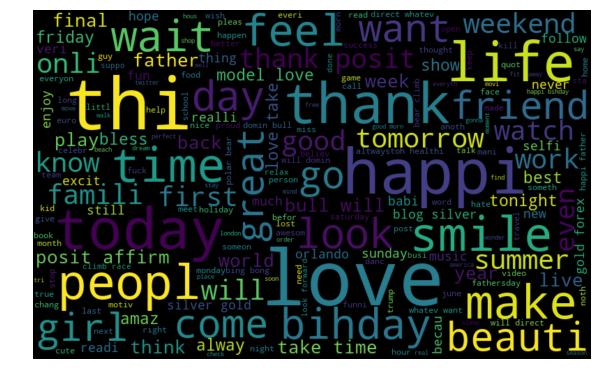

In [21]:
# plotting the wordcloud for the words that appear the most in the positive tweets

positive_words =' '.join([text for text in comp_data['cleaned_tweets'][comp_data['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

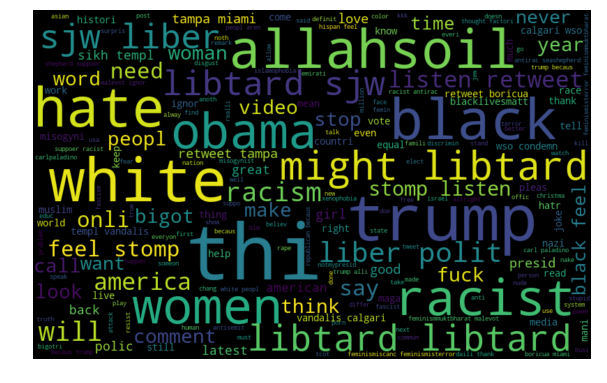

In [22]:
# plotting the wordcloud for the words that appear the most in the negative tweets

negative_words = ' '.join([text for text in comp_data['cleaned_tweets'][comp_data['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [23]:
# defining a function to extract all the hashtags from the tweets

def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [24]:
# extracting hashtags from positive tweets
HT_positive = hashtag_extract(comp_data['cleaned_tweets'][comp_data['label'] == 0])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(comp_data['cleaned_tweets'][comp_data['label'] == 1])

HT_positive

[['run'],
 ['lyft', 'disapoint', 'getthank'],
 [],
 ['model'],
 ['motiv'],
 ['allshowandnogo'],
 [],
 ['school', 'exam', 'hate', 'imagin', 'actorslif', 'revolutionschool', 'girl'],
 ['allin', 'cav', 'champion', 'cleveland', 'clevelandcavali'],
 [],
 ['ireland', 'blog', 'silver', 'gold', 'forex'],
 ['orlando',
  'standwithorlando',
  'pulseshoot',
  'orlandoshoot',
  'biggerproblem',
  'selfish',
  'heabreak',
  'valu',
  'love'],
 ['gettingf'],
 ['got', 'junior', 'yugyoem', 'omg'],
 ['thank', 'posit'],
 ['friday', 'cooki'],
 [],
 ['euro'],
 ['badday', 'coneofsham', 'cat', 'piss', 'funni', 'laugh'],
 ['wine', 'weekend'],
 ['tgif', 'gamedev', 'indiedev', 'indiegamedev', 'squad'],
 ['upsideofflorida', 'shopalyssa', 'love'],
 ['smile', 'media', 'pressconfer', 'antalya', 'turkey', 'throwback'],
 ['ica'],
 [],
 ['rip', 'orlando'],
 [],
 ['alohafriday', 'time', 'not', 'exist', 'positivevib', 'hawaiian'],
 [],
 ['goodnight', 'badmonday'],
 ['taylorswift'],
 ['travelingram', 'dalat', 'ripinkyli

In [25]:
# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])

HT_positive

['run',
 'lyft',
 'disapoint',
 'getthank',
 'model',
 'motiv',
 'allshowandnogo',
 'school',
 'exam',
 'hate',
 'imagin',
 'actorslif',
 'revolutionschool',
 'girl',
 'allin',
 'cav',
 'champion',
 'cleveland',
 'clevelandcavali',
 'ireland',
 'blog',
 'silver',
 'gold',
 'forex',
 'orlando',
 'standwithorlando',
 'pulseshoot',
 'orlandoshoot',
 'biggerproblem',
 'selfish',
 'heabreak',
 'valu',
 'love',
 'gettingf',
 'got',
 'junior',
 'yugyoem',
 'omg',
 'thank',
 'posit',
 'friday',
 'cooki',
 'euro',
 'badday',
 'coneofsham',
 'cat',
 'piss',
 'funni',
 'laugh',
 'wine',
 'weekend',
 'tgif',
 'gamedev',
 'indiedev',
 'indiegamedev',
 'squad',
 'upsideofflorida',
 'shopalyssa',
 'love',
 'smile',
 'media',
 'pressconfer',
 'antalya',
 'turkey',
 'throwback',
 'ica',
 'rip',
 'orlando',
 'alohafriday',
 'time',
 'not',
 'exist',
 'positivevib',
 'hawaiian',
 'goodnight',
 'badmonday',
 'taylorswift',
 'travelingram',
 'dalat',
 'ripinkylif',
 'photoshop',
 'enoughisenough',
 'dontph

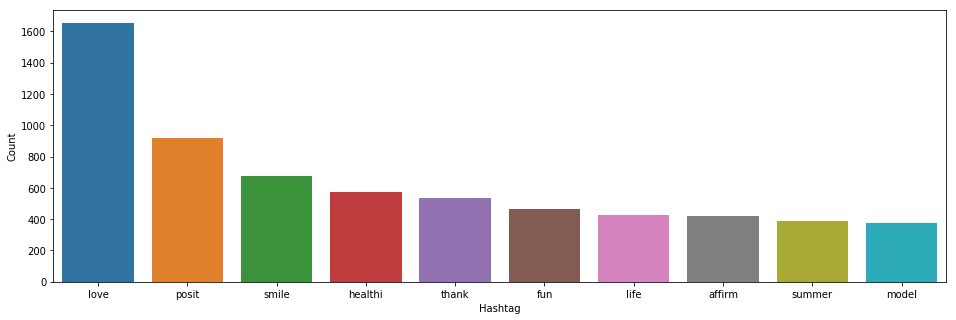

In [26]:
# FreqDist is the sortform of Frequency Distribution. Here we are getting the frequency distribution of the number of 
# occurances of each hashtag in a positive tweet and then storing it as a dataframe to plot a bar graph

ht_count_pos = nltk.FreqDist(HT_positive)
ht_df_pos = pd.DataFrame({'Hashtag': list(ht_count_pos.keys()),
                  'Count': list(ht_count_pos.values())})
# selecting top 10 most frequent hashtags     
ht_df_pos = ht_df_pos.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=ht_df_pos, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

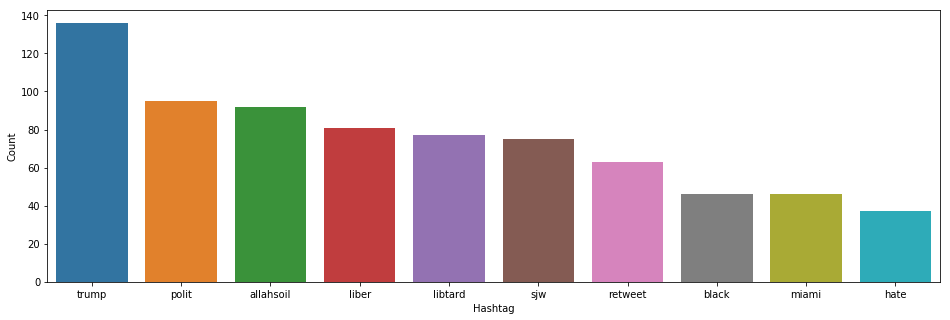

In [27]:
ht_count_neg = nltk.FreqDist(HT_negative)
ht_df_neg = pd.DataFrame({'Hashtag': list(ht_count_neg.keys()), 'Count': list(ht_count_neg.values())})
# selecting top 10 most frequent hashtags
ht_df_neg = ht_df_neg.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=ht_df_neg, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [28]:
# Count Vectorizer creates a bag of words of total count of 1000 elements. The process that is followed by count vectorizer 
# is, it creates a matrix where the number of occurances of each word are checked and then a dictionary is created. Then,
# it sorts this dictionary to get the descending order of the count. The max_feature attribute takes the value which gives
# the top 1000 words which have occured the most in our vocabulary.

bow_vectorizer = CountVectorizer(max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow_fit = bow_vectorizer.fit(comp_data['cleaned_tweets'])
bow =  bow_vectorizer.transform(comp_data['cleaned_tweets']).toarray()
bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [29]:
train_bow = bow[:train_data_len,:]
test_bow = bow[train_data_len:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, y_train, test_size=0.3)

# Logistic Regression Implementation

In [30]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.5819397993311036

# ANN Implementation

In [31]:
input_dim = xtrain_bow.shape[1]

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                10010     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 10,021
Trainable params: 10,021
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(xtrain_bow, ytrain, epochs=5, validation_data=(xvalid_bow, yvalid), batch_size=10)

Train on 22373 samples, validate on 9589 samples
Epoch 1/5
22373/22373 [==============================] - 3s 143us/step - loss: 0.2482 - acc: 0.9300 - val_loss: 0.1977 - val_acc: 0.9296
Epoch 2/5
22373/22373 [==============================] - 3s 114us/step - loss: 0.1723 - acc: 0.9365 - val_loss: 0.1570 - val_acc: 0.9431
Epoch 3/5
22373/22373 [==============================] - 2s 99us/step - loss: 0.1446 - acc: 0.9474 - val_loss: 0.1469 - val_acc: 0.9480
Epoch 4/5
22373/22373 [==============================] - 2s 108us/step - loss: 0.1347 - acc: 0.9515 - val_loss: 0.1454 - val_acc: 0.9493
Epoch 5/5
22373/22373 [==============================] - 2s 107us/step - loss: 0.1302 - acc: 0.9529 - val_loss: 0.1459 - val_acc: 0.9490


In [34]:
loss, accuracy = model.evaluate(xtrain_bow, ytrain)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(xvalid_bow, yvalid)
print("Validation Accuracy: {:.4f}".format(accuracy))

22373/22373 [==============================] - 0s 14us/step
Training Accuracy: 0.9546
9589/9589 [==============================] - 0s 14us/step
Validation Accuracy: 0.9490


In [35]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

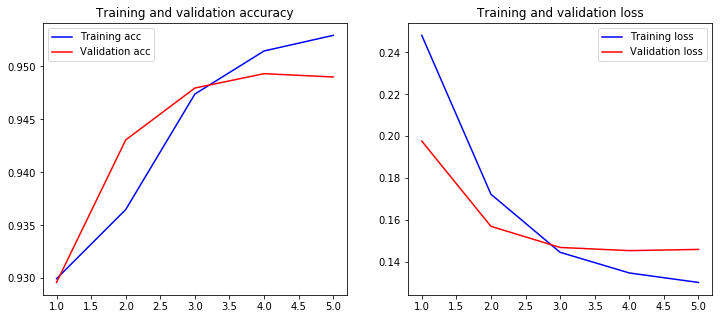

In [36]:
plot_history(history)

In [37]:
result = model.predict(test_bow)

In [38]:
final_result = []

for i in result:
    if i > 0.03:
        final_result.append(0)
    else:
        final_result.append(1)

In [39]:
test_data['label'] = final_result

In [40]:
test_data

,id,tweet,label
0,31963,#studiolife #aislife #requires #passion #dedic...,0
1,31964,@user #white #supremacists want everyone to s...,0
2,31965,safe ways to heal your #acne!! #altwaystohe...,1
3,31966,is the hp and the cursed child book up for res...,1
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",1
5,31968,choose to be :) #momtips,0
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...,1
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...,1
8,31971,@user @user @user i will never understand why...,0
9,31972,#delicious #food #lovelife #capetown mannaep...,1
